In [1]:
#necessary imports

from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2 as pg
import pandas.io.sql as psql
from configparser import ConfigParser

In [2]:
#connect to the database using a function call to a config file for security for params
def config(filename='database.ini', section='connection_params'):
    parser = ConfigParser()
    parser.read(filename)
    params = parser.items(section) #parses into 2-tuples
    
    return params

#specify value attribute of each param, not the variable attribute
params = config()
conn = pg.connect(host=params[0][1], database=params[1][1], user=params[2][1], password=params[3][1], port=params[4][1])

In [3]:
#use connection and pandas.io.sql to read postgres tables into pandas DataFrames

In [4]:
titles_df = psql.read_sql("SELECT * FROM titles", conn)
titles_df.head()

,title_id,titles
0,s0001,Staff
1,s0002,Senior Staff
2,e0001,Assistant Engineer
3,e0002,Engineer
4,e0003,Senior Engineer


In [5]:
employees_df = psql.read_sql("SELECT * FROM employees", conn)
employees_df.head()

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date
0,473302,s0001,1953-07-25,Hideyuki,Zallocco,M,1990-04-28
1,475053,e0002,1954-11-18,Byong,Delgrande,F,1991-09-07
2,57444,e0002,1958-01-30,Berry,Babb,F,1992-03-21
3,421786,s0001,1957-09-28,Xiong,Verhoeff,M,1987-11-26
4,282238,e0003,1952-10-28,Abdelkader,Baumann,F,1991-01-18


In [6]:
departments_df = psql.read_sql("SELECT * FROM departments", conn)
departments_df.head()

,dept_no,dept_name
0,d001,Marketing
1,d002,Finance
2,d003,Human Resources
3,d004,Production
4,d005,Development


In [7]:
dept_managers_df = psql.read_sql("SELECT * FROM dept_managers", conn)
dept_managers_df.head()

,dept_no,emp_no
0,d001,110022
1,d001,110039
2,d002,110085
3,d002,110114
4,d003,110183


In [8]:
dept_emp_df = psql.read_sql("SELECT * FROM dept_emp", conn)
dept_emp_df.head()

,emp_no,dept_no
0,10001,d005
1,10002,d007
2,10003,d004
3,10004,d004
4,10005,d003


In [9]:
salaries_df = psql.read_sql("SELECT * FROM salaries", conn)
salaries_df.head()

,emp_no,salary
0,10001,60117
1,10002,65828
2,10003,40006
3,10004,40054
4,10005,78228


In [10]:
#Create a histogram to visualize the most common salary ranges for employees

In [11]:
#find max and min salary to determine bins for ranges, make bins and labels
print(salaries_df['salary'].max())
print(salaries_df['salary'].min())

bins = [39999, 49999, 59999, 69999, 79999, 89999, 99999, 109999, 119999, 130000]
labels = ['40K-49K', '50K-59K', '60K-69K', '70K-79K', '80K-89K', '90K-99K', '100K-109K', '110K-119K', '120K-130K']

129492
40000


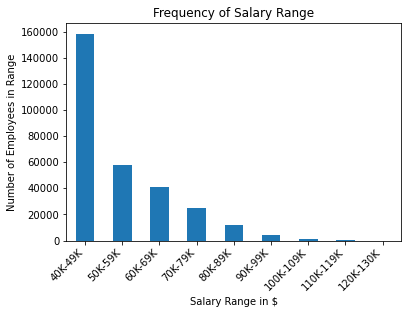

In [12]:
#a bar chart of employee count per salary range that functions as a histogram, 
#but is more customizable and more concise to write
salaries_df['Salary Range'] = pd.cut(salaries_df['salary'], bins, labels=labels)
salaries_counts = salaries_df['Salary Range'].value_counts()

bar_chart_salary_freq = salaries_counts.plot.bar(title='Frequency of Salary Range', xlabel='Salary Range in $', ylabel='Number of Employees in Range', rot=45)
plt.xticks(horizontalalignment='right')
plt.show()

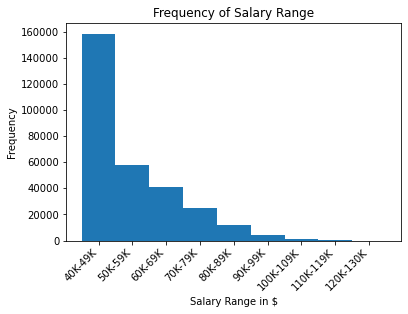

In [13]:
#a proper histogram of salary ranges

#access ax for commands
fig, ax = plt.subplots()

#set indent array and calculate widths of bins per instance into an array
ind = np.array(bins[:-1])
width = np.array([bins[i+1]-bins[i] for i in range(len(bins)-1)])

ax.hist(salaries_df['salary'], bins=bins)
ax.set_xticks(ind + width/2)
ax.set_xticklabels((labels), rotation=45) 
plt.xlabel('Salary Range in $')
plt.ylabel('Frequency')
plt.title('Frequency of Salary Range')
plt.xticks(horizontalalignment='right')
plt.show()

In [14]:
#Create a bar chart of average salary by title

In [15]:
#merge employees, salaries, and titles to get variables required
#rename 'emp_title_id' to match its counterpart 'title_id' for the merge
employee_salary_df = employees_df.merge(salaries_df, on=['emp_no'], how='inner')
employee_salary_df.rename(columns={'emp_title_id':'title_id'}, inplace=True)
employee_salary_title_df = employee_salary_df.merge(titles_df, on=['title_id'], how='inner')
employee_salary_title_df.head()


,emp_no,title_id,birth_date,first_name,last_name,sex,hire_date,salary,Salary Range,titles
0,473302,s0001,1953-07-25,Hideyuki,Zallocco,M,1990-04-28,40000,40K-49K,Staff
1,421786,s0001,1957-09-28,Xiong,Verhoeff,M,1987-11-26,40000,40K-49K,Staff
2,273487,s0001,1957-04-14,Christoph,Parfitt,M,1991-06-28,56087,50K-59K,Staff
3,246449,s0001,1958-03-23,Subbu,Bultermann,F,1988-03-25,87084,80K-89K,Staff
4,48085,s0001,1964-01-19,Venkatesan,Gilg,M,1993-06-28,63016,60K-69K,Staff


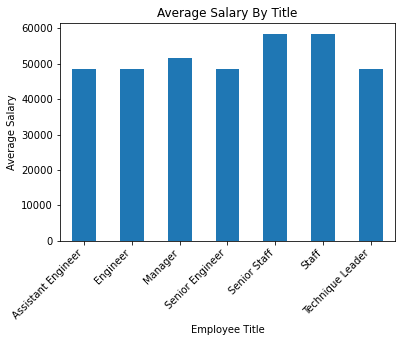

In [16]:
#group data by title and then by salaries applying to those titles, taking the mean salary per title
avg_salaries = employee_salary_title_df.groupby(['titles'])['salary'].mean()

bar_chart_avg_salaries = avg_salaries.plot.bar(title='Average Salary By Title', xlabel='Employee Title', ylabel='Average Salary', rot=45)
plt.xticks(horizontalalignment='right')
plt.show()

In [ ]:
#boxplot
fig, ax = plt.subplots()
ax.set_title('Salary Analysis by Title')
ax.set_ylabel('Salary')
ax.set_xlabel('Employee Title')

labels = employee_salary_title_df['titles'].unique()
print(labels)
singleValues = []
values = []
for title in labels:
    for row in employee_salary_title_df.iterrows():
        singleValues.append(employee_salary_title_df.loc[employee_salary_title_df['titles'] == title, 'salary'])
    values.append(singleValues.mean())
    singleValues = []
print(values)
#ax.boxplot(values, labels, flierprops=dict(markerfacecolor='red'))

['Staff' 'Engineer' 'Senior Engineer' 'Senior Staff' 'Technique Leader'
 'Assistant Engineer' 'Manager']


In [ ]:
#comments to boss

# I found evidence that the employee data given to me is not valid data. I made a histogram plus bar chart of frequency of
# main salary groups (group ranges of $10K), and then made a bar chart of average salaries per title.  A couple of things
# stood out; the range frequency data is not even close to normally distributed, there is almost no variation in average
# salaries per title, and there are illogical relationships between average salaries per title. For example, a Senior Engineer's
# average salary is less than that of an Engineer, and both are less than the average salary of a Junior Engineer. Equally 
# illogical is the fact that a Senior Staff's average salary is less than a Manager's. 

In [ ]:
#running id number 499942
data_499942 = employee_salary_title_df.loc[employee_salary_title_df['emp_no'] == 499942]
data_499942

In [ ]:
#April Fool's back atcha!